In [2]:
!conda install -c conda-forge shap --yes
!pip install smdebug --upgrade

Channels:
 - conda-forge
 - defaults
Platform: linux-64

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


/ Collecting smdebug
  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (679 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.24.4
    Uninstalling protobuf-4.24.4:
      Successfully uninstalled protobuf-4.24.4


In [3]:
!pip install s3fs shap

  Using cached s3fs-2024.6.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached shap-0.45.1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (24 kB)
  Using cached fsspec-2024.6.0-py3-none-any.whl.metadata (11 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
Using cached s3fs-2024.6.0-py3-none-any.whl (29 kB)
Using cached fsspec-2024.6.0-py3-none-any.whl (176 kB)
Using cached shap-0.45.1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (540 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
      Successfully uninstalled fsspec-2023.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-ai 2.15.0 requires faiss

In [4]:
import re
import s3fs
import shap
import time
import boto3
import pandas as pd
import numpy as np

from itertools import islice
import matplotlib.pyplot as plt

import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import DebuggerHookConfig,CollectionConfig
from sagemaker.debugger import rule_configs, Rule
from smdebug.trials import create_trial
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
[2024-06-09 12:31:34.166 default:112 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [5]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name
region

'us-east-2'

In [6]:
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    ## Convert to datetime columns
    df["firstorder"]=pd.to_datetime(df["firstorder"],errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
    ## Drop Rows with null values
    df = df.dropna()
    ## Create Column which gives the days between the last order and the first order
    df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
    ## Create Column which gives the days between when the customer record was created and the first order
    df['created'] = pd.to_datetime(df['created'])
    df['created_first_days_diff']=(df['created']-df['firstorder']).dt.days
    ## Drop Columns
    df.drop(['custid','created','firstorder','lastorder'],axis=1,inplace=True)
    ## Apply one hot encoding on favday and city columns
    df = pd.get_dummies(df,prefix=['favday','city'],columns=['favday','city'])
    return df

In [34]:
# storedata = preprocess_data('churn-modelling/data/storedata_total.csv')
default_bucket = 'sagemaker-studio-891376975801-3j1752jty8h'
storedata = preprocess_data(f"s3://{default_bucket}/data/storedata_total.csv")

In [35]:
storedata.head()

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,...,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BLR,city_BOM,city_DEL,city_MAA
0,0,29,100.000000,3.448276,14.52,0.000000,0,0,0,0,...,True,False,False,False,False,False,False,False,True,False
1,1,95,92.631579,10.526316,83.69,0.181641,1,1,1,1024,...,False,False,False,False,False,False,False,False,True,False
2,0,0,0.000000,0.000000,33.58,0.059908,0,0,0,217,...,False,False,False,False,False,True,False,False,True,False
3,0,0,0.000000,0.000000,54.96,0.000000,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,30,90.000000,13.333333,111.91,0.008850,0,0,0,791,...,True,False,False,False,False,False,False,True,False,False


In [36]:
## Set the required configurations
model_name = "churn_model"
env = "dev"

In [37]:
def split_datasets(df):
    y=df.pop("retained")
    X_pre = df
    y_pre = y.to_numpy().reshape(len(y),1)
    feature_names = list(X_pre.columns)
    X= np.concatenate((y_pre,X_pre),axis=1)
    np.random.shuffle(X)
    train,validation,test=np.split(X,[int(.7*len(X)),int(.85*len(X))])
    return feature_names,train,validation,test

# Split dataset
feature_names,train,validation,test = split_datasets(storedata)

In [38]:
print(feature_names)

['esent', 'eopenrate', 'eclickrate', 'avgorder', 'ordfreq', 'paperless', 'refill', 'doorstep', 'first_last_days_diff', 'created_first_days_diff', 'favday_Friday', 'favday_Monday', 'favday_Saturday', 'favday_Sunday', 'favday_Thursday', 'favday_Tuesday', 'favday_Wednesday', 'city_BLR', 'city_BOM', 'city_DEL', 'city_MAA']


In [39]:
train

array([[1, 36, 58.33333333, ..., False, False, True],
       [1, 45, 8.888888889, ..., False, True, False],
       [1, 43, 18.60465116, ..., False, True, False],
       ...,
       [1, 28, 75.0, ..., False, False, True],
       [1, 30, 10.0, ..., True, False, False],
       [1, 27, 74.07407407, ..., False, False, True]], dtype=object)

In [40]:
validation

array([[1, 45, 8.888888889, ..., False, False, True],
       [1, 26, 76.92307692, ..., False, True, False],
       [1, 26, 53.84615385, ..., False, True, False],
       ...,
       [1, 27, 22.22222222, ..., False, False, True],
       [1, 11, 54.54545455, ..., False, True, False],
       [1, 10, 70.0, ..., True, False, False]], dtype=object)

In [16]:
test

array([[0, 19, 5.263157895, ..., True, False, False],
       [1, 30, 96.66666667, ..., False, True, False],
       [1, 32, 18.75, ..., False, False, True],
       ...,
       [0, 17, 11.76470588, ..., True, False, False],
       [0, 0, 0.0, ..., False, True, False],
       [1, 43, 16.27906977, ..., False, True, False]], dtype=object)

In [41]:
pd.DataFrame(train).to_csv(f"s3://{default_bucket}/data/train/train.csv",header=False,index=False)
pd.DataFrame(validation).to_csv(f"s3://{default_bucket}/data/validation/validation.csv",header=False,index=False)
pd.DataFrame(test).to_csv(f"s3://{default_bucket}/data/test/test.csv",header=False,index=False)

In [42]:
s3_input_train = TrainingInput(
    s3_data=f"s3://{default_bucket}/data/train/",content_type="csv")
s3_input_validation = TrainingInput(
    s3_data=f"s3://{default_bucket}/data/validation/",content_type="csv")

In [43]:
fixed_hyperparameters = {
    "eval_metric":"auc",
    "objective":"binary:logistic",
    "num_round":"100",
    "rate_drop":"0.3",
    "tweedie_variance_power":"1.4"
}

In [44]:
sess = sagemaker.Session()
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sagemaker_session
)

In [45]:
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}

In [46]:
objective_metric_name = "validation:auc"

In [47]:
tuner = HyperparameterTuner(
    estimator,objective_metric_name,hyperparameter_ranges,max_jobs=10,max_parallel_jobs=2)

In [48]:
tuner.fit({
    "train":s3_input_train,
    "validation":s3_input_validation
    },include_cls_metadata=False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................!


In [49]:
## Explore the best model generated
tuning_job_result = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" %job_count)

## Get the best training job

from pprint import pprint
if tuning_job_result.get("BestTrainingJob",None):
    print("Best Model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

10 training jobs have completed
Best Model found so far:
{'CreationTime': datetime.datetime(2024, 6, 9, 13, 29, 33, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.9763540029525757},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2024, 6, 9, 13, 30, 9, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:891376975801:training-job/sagemaker-xgboost-240609-1325-008-6b84dd44',
 'TrainingJobName': 'sagemaker-xgboost-240609-1325-008-6b84dd44',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2024, 6, 9, 13, 29, 36, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '1.9548845016328644',
                          'eta': '0.22718926547086682',
                          'max_depth': '7',
                          'min_child_weight': '6.055610735432826'}}


In [50]:
best_hyperparameters = tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

In [51]:
best_hyperparameters

{'alpha': '1.9548845016328644',
 'eta': '0.22718926547086682',
 'max_depth': '7',
 'min_child_weight': '6.055610735432826'}

In [52]:
hyperparameters = {**fixed_hyperparameters,**best_hyperparameters}
save_interval = 5
base_job_name = "demo-smdebug-xgboost-churn-classification"

In [53]:
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

In [54]:
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sess,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path=f"s3://{default_bucket}/debugger/",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "5"
                }),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": "5"}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": "5"}),
            CollectionConfig(name="average_shap", parameters={"save_interval": "5"}),
        ]
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ]
)

In [55]:
estimator.fit(
        {"train":s3_input_train,"validation":s3_input_validation},wait=False
    )

INFO:sagemaker:Creating training-job with name: demo-smdebug-xgboost-churn-classificati-2024-06-09-13-40-22-394


In [56]:
for _ in range(36):
    job_name = estimator.latest_training_job.name
    client = estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )
    if training_job_status in ["Completed", "Failed"]:
        break
    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation

In [57]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:891376975801:processing-job/demo-smdebug-xgboost-churn-LossNotDecreasing-ae600e10',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2024, 6, 9, 13, 44, 47, 395000, tzinfo=tzlocal())}]

In [59]:
s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)
trial.tensor_names()

[2024-06-09 13:45:27.333 default:112 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-studio-891376975801-3j1752jty8h/debugger/demo-smdebug-xgboost-churn-classificati-2024-06-09-13-40-22-394/debug-output
[2024-06-09 13:45:28.025 default:112 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-06-09 13:45:29.041 default:112 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f5',
 'feature_importance/gain/f6',
 'feature_importance/gain/f7',
 

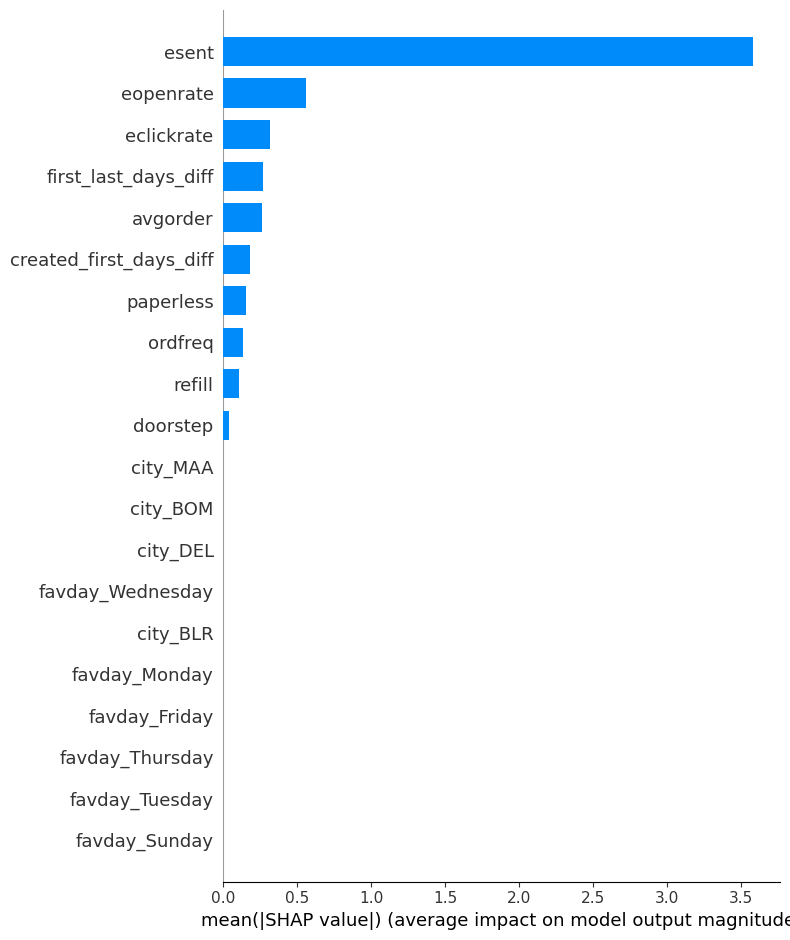

In [60]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [61]:
train_shap = pd.DataFrame(train[:,1:],columns=feature_names)

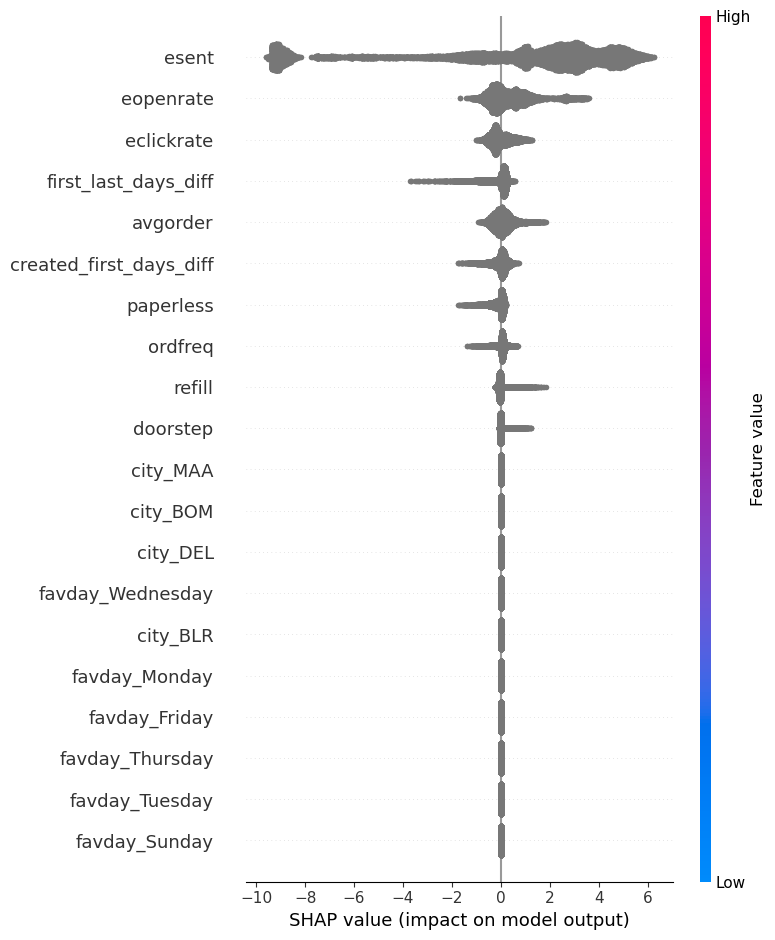

In [62]:
shap.summary_plot(shap_no_base, train_shap)

In [ ]:
# processing step for feature engineering
sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    sagemaker_session=sagemaker_session,
    role=role,
)
step_process = ProcessingStep(
    name="ChurnModelProcess",
    processor=sklearn_processor,
    inputs=[
      ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),  
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train",\
                         destination=f"s3://{default_bucket}/output/train" ),
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation",\
                        destination=f"s3://{default_bucket}/output/validation"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test",\
                        destination=f"s3://{default_bucket}/output/test")
    ],
    code=f"s3://{default_bucket}/input/code/preprocess.py",
)